# Enexis Case Data Exploration

This notebook explores the Enexis case data. It imports the data, cleans up all kinds of inconsistencies and small problems, so that we have a clean set of data to work with.

---
## Dependency Installation and Imports

This cell installs the dependencies and packages used by Python.

In [1]:
!pip install pandas chardet matplotlib --quiet


With the installation done we import the dependencies. During import, we print version numbers of key components, in case we need that for troubleshooting. We also define a bunch of constants that will help make the code more readable.

In [2]:
import os
import re
import sys
import json
from os.path import exists
from datetime import datetime
print("python=={}".format(re.sub(r'\s.*', '', sys.version)))

import pandas as pd
print(f"pandas=={pd.__version__}")
ROW    = 0
COLUMN = 1
STRING = 'string'
OBJECT = 'object'
NUMBER = 'number'
CATEGORY = 'category'
INTEGER = 'integer'
UNSIGNED = 'unsigned'
FLOAT = 'float'

import numpy as np
print(f"numpy=={np.__version__}")

import matplotlib.pyplot as plt
from matplotlib import __version__ as matplotlib__version__
print(f"matplotlib=={matplotlib__version__}")

import chardet
print(f"chardet=={chardet.__version__}")


python==3.10.9
pandas==2.0.0
numpy==1.24.2
matplotlib==3.7.1
chardet==5.1.0


---
## Lists

Lists are a handy way to make a code readable and to document what is happening and to what.


In [3]:
DATA_DIR = "../data"
CACHE_DIR = "../cache"

DECENTRALE_OPWEK = [f"{DATA_DIR}/{each}" for each in os.listdir(DATA_DIR) if 'decentrale_opwek' in each]
KLEINVERBRUIKSGEGEVENS = [f"{DATA_DIR}/{each}" for each in os.listdir(DATA_DIR) if 'kleinverbruiksgegevens' in each]
OPWEKDATA_GV = [f"{DATA_DIR}/{each}" for each in os.listdir(DATA_DIR) if 'opwekdata_gv' in each]

KLEINVERBRUIK_CATEGORICAL = [
    'NETBEHEERDER',
    'NETGEBIED',
    'STRAATNAAM',
    'POSTCODE_VAN',
    'POSTCODE_TOT',
    'WOONPLAATS',
    'LANDCODE',
    'PRODUCTSOORT',
    'VERBRUIKSSEGMENT',
    'SOORT_AANSLUITING']


---
## Dealing with File Encodings

The files have a bit of a mix of encodings. To make matters worse, the `chardet` library takes several minutes to analyse all files. To work around this, we create a list of encodings and cache that in `cache/file_encodings.json` for reference. This means the first time you run this notebook will take a lot of time, but it gets quicker afterwards.

In [4]:
FILE_ENCODING_CACHE = f"{CACHE_DIR}/file_encodings.json"

if not exists(CACHE_DIR):
    os.mkdir(CACHE_DIR)

file_encodings = {}
if exists(FILE_ENCODING_CACHE):
    with open(FILE_ENCODING_CACHE) as cache:
        file_encodings = json.load(cache)

for file in DECENTRALE_OPWEK + KLEINVERBRUIKSGEGEVENS + OPWEKDATA_GV:
    if file not in file_encodings:
        print(f"finding file encoding for {file}. This may take a few minutes...")
        rawdata = open(file, "rb").read()
        file_encodings.update({file: chardet.detect(rawdata)['encoding']})
        with open(FILE_ENCODING_CACHE, "w") as cache:
            json.dump(file_encodings , cache, indent=4, sort_keys=True) 


---
## Load Kleinverbruik


In [5]:
li = []
for file in KLEINVERBRUIKSGEGEVENS:
    df = pd.read_csv(file, index_col=None, sep = ';', decimal=',', thousands='.', encoding=file_encodings[file])

    # some columns names have spaces around them and those may be different per file
    df.columns = df.columns.str.strip()

    match = re.search(r'_\d{2}\d{2}\d{4}\.csv', file)
    date = datetime.strptime(match.group(), '_%d%m%Y.csv').date()
    df['PEILDATUM'] = pd.to_datetime(date)

    df.rename({'SJA_LAAG_TARIEF_PERC': 'SJV_LAAG_TARIEF_PERC', 'SJA_GEMIDDELD': 'SJV_GEMIDDELD'}, axis=1, inplace=True)
    
    li.append(df)

kleinverbruik = pd.concat(li, axis=0, ignore_index=True)

# convert integers to smallest unsigned integer and floats to smallest
for old, new in [(INTEGER, UNSIGNED), (FLOAT, FLOAT)]:
    for col in kleinverbruik.select_dtypes(include=old).columns:
        kleinverbruik[col] = pd.to_numeric(kleinverbruik[col], downcast=new)

kleinverbruik[KLEINVERBRUIK_CATEGORICAL] = kleinverbruik[KLEINVERBRUIK_CATEGORICAL].astype(CATEGORY)

# drop columns that only have a single distinct value
for col in kleinverbruik.columns:
    if len(kleinverbruik[col].unique()) == 1:
        print(f"kleinverbruik: dropping column {col} since it only has one distinct value")
        kleinverbruik.drop(col, inplace=True, axis=1)
kleinverbruik.drop('NETBEHEERDER', inplace=True, axis=1) # also useless has two values: 'Enexis B.V.' and 'Enexis'
print(f"kleinverbruik: dropping column NETBEHEERDER since it only has one distinct value (effectively)")

kleinverbruik


kleinverbruik: dropping column NETGEBIED since it only has one distinct value
kleinverbruik: dropping column LANDCODE since it only has one distinct value
kleinverbruik: dropping column VERBRUIKSSEGMENT since it only has one distinct value
kleinverbruik: dropping column FYSIEKE_STATUS_PERC since it only has one distinct value
kleinverbruik: dropping column NETBEHEERDER since it only has one distinct value (effectively)


,STRAATNAAM,POSTCODE_VAN,POSTCODE_TOT,WOONPLAATS,PRODUCTSOORT,LEVERINGSRICHTING_PERC,AANSLUITINGEN_AANTAL,SOORT_AANSLUITING_PERC,SOORT_AANSLUITING,SJV_GEMIDDELD,SJV_LAAG_TARIEF_PERC,SLIMME_METER_PERC,PEILDATUM
0,Sasdijk,4251AB,4251AB,WERKENDAM,ELK,100.000000,16,NaN,NaN,4282.00,25.000000,0.000000,2010-01-01
1,Sasdijk,4251AC,4251AC,WERKENDAM,ELK,100.000000,11,NaN,NaN,5113.00,10.000000,0.000000,2010-01-01
2,Sasdijk,4251AD,4251AD,WERKENDAM,ELK,100.000000,30,NaN,NaN,4809.00,34.000000,0.000000,2010-01-01
3,Nieuweweg,4251AE,4251AG,WERKENDAM,ELK,100.000000,21,NaN,NaN,5015.00,44.000000,0.000000,2010-01-01
4,Koppenhof,4251AH,4251AH,WERKENDAM,ELK,100.000000,12,NaN,NaN,3074.00,22.000000,0.000000,2010-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035151,Knolweg,9998XE,9999XG,ROTTUM GN,GAS,100.000000,12,75.000000,G4,3603.58,0.000000,NaN,2023-01-01
3035152,Stitswerderweg,9999XH,9999XJ,STITSWERD,ELK,40.000000,15,60.000000,3x25,6944.07,31.850000,73.330002,2023-01-01
3035153,Stitswerderweg,9999XH,9999XJ,STITSWERD,GAS,100.000000,14,92.860001,G4,2510.29,0.000000,NaN,2023-01-01
3035154,Stiel,9999XK,9999XL,STITSWERD,ELK,42.860001,21,61.900002,3x25,2507.62,40.490002,76.190002,2023-01-01


In [6]:
kleinverbruik.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3035156 entries, 0 to 3035155
Data columns (total 13 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   STRAATNAAM              category      
 1   POSTCODE_VAN            category      
 2   POSTCODE_TOT            category      
 3   WOONPLAATS              category      
 4   PRODUCTSOORT            category      
 5   LEVERINGSRICHTING_PERC  float32       
 6   AANSLUITINGEN_AANTAL    uint16        
 7   SOORT_AANSLUITING_PERC  float32       
 8   SOORT_AANSLUITING       category      
 9   SJV_GEMIDDELD           float64       
 10  SJV_LAAG_TARIEF_PERC    float32       
 11  SLIMME_METER_PERC       float32       
 12  PEILDATUM               datetime64[ns]
dtypes: category(6), datetime64[ns](1), float32(4), float64(1), uint16(1)
memory usage: 167.5 MB


In [7]:
kleinverbruik.describe(include=NUMBER)


,LEVERINGSRICHTING_PERC,AANSLUITINGEN_AANTAL,SOORT_AANSLUITING_PERC,SJV_GEMIDDELD,SJV_LAAG_TARIEF_PERC,SLIMME_METER_PERC
count,3.031228e+06,3.035156e+06,2.844678e+06,3.035156e+06,3.035156e+06,1.642991e+06
mean,9.473505e+01,2.140554e+01,7.897491e+01,3.354803e+03,2.167278e+01,4.223762e+01
std,1.286527e+01,1.180638e+01,2.012187e+01,3.058042e+03,2.290897e+01,4.034133e+01
min,0.000000e+00,1.000000e+01,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
25%,9.792000e+01,1.500000e+01,6.207000e+01,1.722000e+03,0.000000e+00,0.000000e+00
50%,1.000000e+02,1.900000e+01,8.421000e+01,2.651000e+03,1.400000e+01,2.400000e+01
75%,1.000000e+02,2.400000e+01,1.000000e+02,3.798700e+03,4.525000e+01,8.750000e+01
max,1.000000e+02,6.930000e+02,1.000000e+02,7.304300e+04,2.225000e+03,1.000000e+02


In [8]:
kleinverbruik.describe(include=NUMBER)


,LEVERINGSRICHTING_PERC,AANSLUITINGEN_AANTAL,SOORT_AANSLUITING_PERC,SJV_GEMIDDELD,SJV_LAAG_TARIEF_PERC,SLIMME_METER_PERC
count,3.031228e+06,3.035156e+06,2.844678e+06,3.035156e+06,3.035156e+06,1.642991e+06
mean,9.473505e+01,2.140554e+01,7.897491e+01,3.354803e+03,2.167278e+01,4.223762e+01
std,1.286527e+01,1.180638e+01,2.012187e+01,3.058042e+03,2.290897e+01,4.034133e+01
min,0.000000e+00,1.000000e+01,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
25%,9.792000e+01,1.500000e+01,6.207000e+01,1.722000e+03,0.000000e+00,0.000000e+00
50%,1.000000e+02,1.900000e+01,8.421000e+01,2.651000e+03,1.400000e+01,2.400000e+01
75%,1.000000e+02,2.400000e+01,1.000000e+02,3.798700e+03,4.525000e+01,8.750000e+01
max,1.000000e+02,6.930000e+02,1.000000e+02,7.304300e+04,2.225000e+03,1.000000e+02


In [9]:
kleinverbruik['slimme_meter_aantal'] = kleinverbruik['AANSLUITINGEN_AANTAL'] * kleinverbruik['SLIMME_METER_PERC'] / 100.0
kleinverbruik


,STRAATNAAM,POSTCODE_VAN,POSTCODE_TOT,WOONPLAATS,PRODUCTSOORT,LEVERINGSRICHTING_PERC,AANSLUITINGEN_AANTAL,SOORT_AANSLUITING_PERC,SOORT_AANSLUITING,SJV_GEMIDDELD,SJV_LAAG_TARIEF_PERC,SLIMME_METER_PERC,PEILDATUM,slimme_meter_aantal
0,Sasdijk,4251AB,4251AB,WERKENDAM,ELK,100.000000,16,NaN,NaN,4282.00,25.000000,0.000000,2010-01-01,0.0000
1,Sasdijk,4251AC,4251AC,WERKENDAM,ELK,100.000000,11,NaN,NaN,5113.00,10.000000,0.000000,2010-01-01,0.0000
2,Sasdijk,4251AD,4251AD,WERKENDAM,ELK,100.000000,30,NaN,NaN,4809.00,34.000000,0.000000,2010-01-01,0.0000
3,Nieuweweg,4251AE,4251AG,WERKENDAM,ELK,100.000000,21,NaN,NaN,5015.00,44.000000,0.000000,2010-01-01,0.0000
4,Koppenhof,4251AH,4251AH,WERKENDAM,ELK,100.000000,12,NaN,NaN,3074.00,22.000000,0.000000,2010-01-01,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035151,Knolweg,9998XE,9999XG,ROTTUM GN,GAS,100.000000,12,75.000000,G4,3603.58,0.000000,NaN,2023-01-01,NaN
3035152,Stitswerderweg,9999XH,9999XJ,STITSWERD,ELK,40.000000,15,60.000000,3x25,6944.07,31.850000,73.330002,2023-01-01,10.9995
3035153,Stitswerderweg,9999XH,9999XJ,STITSWERD,GAS,100.000000,14,92.860001,G4,2510.29,0.000000,NaN,2023-01-01,NaN
3035154,Stiel,9999XK,9999XL,STITSWERD,ELK,42.860001,21,61.900002,3x25,2507.62,40.490002,76.190002,2023-01-01,15.9999


In [10]:
# this means that we don't have much confidence in the generated numbers, since the old
# dumb meters would just run backwards and thus we cannot see the generated numbers with old meters.

# old meter: use = actual use - actual generated; generated = 0
# new meter: use = actual use; generated is actual generated (doublecheck: does generated and then locally used go via the meter or is it invisible?)

# Note that `GAS` never has anythoing but 0 for 'SLIMME_METER_PERC'.

kleinverbruik[kleinverbruik['PRODUCTSOORT'] == 'ELK'].groupby(['PEILDATUM'])['SLIMME_METER_PERC'].mean()


PEILDATUM
2010-01-01     0.277950
2011-01-01     0.577152
2012-01-01     2.585485
2013-01-01     6.082191
2014-01-01    10.920136
2015-01-01    17.714586
2016-01-01    24.809843
2017-01-01    38.212944
2018-01-01    51.477879
2019-01-01    65.212967
2020-01-01    78.998962
2021-01-01    85.787094
2022-01-01    89.644211
2023-01-01    91.568581
Name: SLIMME_METER_PERC, dtype: float32

In [11]:
kleinverbruik[kleinverbruik['PRODUCTSOORT'] == 'GAS'].groupby(['PEILDATUM'])['SLIMME_METER_PERC'].mean()


PEILDATUM
2010-01-01   NaN
2011-01-01   NaN
2012-01-01   NaN
2013-01-01   NaN
2014-01-01   NaN
2015-01-01   NaN
2016-01-01   NaN
2017-01-01   NaN
2018-01-01   NaN
2019-01-01   NaN
2020-01-01   NaN
2021-01-01   NaN
2022-01-01   NaN
2023-01-01   NaN
Name: SLIMME_METER_PERC, dtype: float32

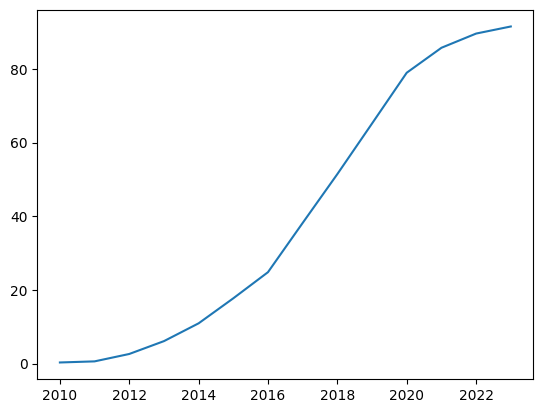

In [12]:
plt.plot(kleinverbruik['PEILDATUM'].unique(), kleinverbruik[kleinverbruik['PRODUCTSOORT'] == 'ELK'].groupby(['PEILDATUM'])['SLIMME_METER_PERC'].mean());


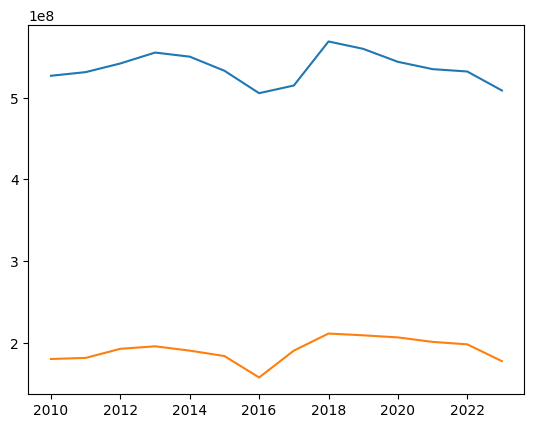

In [13]:
plt.plot(kleinverbruik['PEILDATUM'].unique(), kleinverbruik[kleinverbruik['PRODUCTSOORT'] == 'ELK'].groupby(['PEILDATUM'])['SJV_GEMIDDELD'].sum())
plt.plot(kleinverbruik['PEILDATUM'].unique(), kleinverbruik[kleinverbruik['PRODUCTSOORT'] == 'GAS'].groupby(['PEILDATUM'])['SJV_GEMIDDELD'].sum());


In [14]:
kleinverbruik[kleinverbruik['PRODUCTSOORT'] == 'ELK'].groupby(['PEILDATUM'])['SJV_GEMIDDELD'].sum()


PEILDATUM
2010-01-01    5.265813e+08
2011-01-01    5.310414e+08
2012-01-01    5.416147e+08
2013-01-01    5.549411e+08
2014-01-01    5.499293e+08
2015-01-01    5.327039e+08
2016-01-01    5.052923e+08
2017-01-01    5.146683e+08
2018-01-01    5.684906e+08
2019-01-01    5.594730e+08
2020-01-01    5.436398e+08
2021-01-01    5.346820e+08
2022-01-01    5.317946e+08
2023-01-01    5.085763e+08
Name: SJV_GEMIDDELD, dtype: float64

In [15]:
kleinverbruik[kleinverbruik['PRODUCTSOORT'] == 'ELK'].groupby(['PEILDATUM'])['AANSLUITINGEN_AANTAL'].sum()


PEILDATUM
2010-01-01    2311361
2011-01-01    2338819
2012-01-01    2395738
2013-01-01    2499429
2014-01-01    2511449
2015-01-01    2522314
2016-01-01    2454083
2017-01-01    2583882
2018-01-01    2636035
2019-01-01    2653261
2020-01-01    2666499
2021-01-01    2684511
2022-01-01    2698610
2023-01-01    2719406
Name: AANSLUITINGEN_AANTAL, dtype: uint64

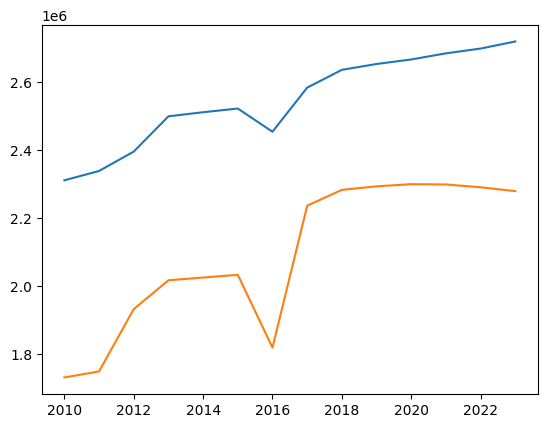

In [16]:
# It looks a lot like we are missing records in the 2016 data file

plt.plot(kleinverbruik['PEILDATUM'].unique(), kleinverbruik[kleinverbruik['PRODUCTSOORT'] == 'ELK'].groupby(['PEILDATUM'])['AANSLUITINGEN_AANTAL'].sum())
plt.plot(kleinverbruik['PEILDATUM'].unique(), kleinverbruik[kleinverbruik['PRODUCTSOORT'] == 'GAS'].groupby(['PEILDATUM'])['AANSLUITINGEN_AANTAL'].sum());
